#Introduction

In this notebook, we used a network composed of 5 convolutional blocks, composed by a convolution and a pool each, plus two fully connected layers with dropout. We have done some **modification to the dataset**:


*   We split the dataset with our script in:
    *   $75$% training set
    *   $15$% validation set
    *   $10$% test set
*   We balanced the dataset with the script made by us. We set $550$ as threshold for the training set, while $250$ for the validation set. We did not change the test set.

**Augmentation**:

*   We applied data augmentation, in order to avoid overfitting due to some classes which had really few samples in them, like the Raspberry one. This helped also to "fill" a little bit the gap due to the difference of our sets and the test set on the server.

**Patience** was set to $10$, and **Learning Rate** to $0,0001$.

With this notebook we got a score of $70,57$%

#Mounting Drive

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Checking which GPU I am running on

In [ ]:
!nvidia-smi

#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

Extracting the zipped archive into the folder in which I am when I start the notebook (/content). We did this, because by extracting the zipped archive in the local folder of the runtime, speeds up a lot the first epoch in google Colab, and make its duration as shord as the following ones. This allowed us to save a lot of GPU time.

In [ ]:
!unzip /gdrive/MyDrive/AN2DL/leaves_test_overUnder_sampled.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02033.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01856.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01704.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01880.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02206.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02218.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01849.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/0_02151.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/1_01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/2_02222.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/3_01720.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/4_01745.jpg  
  inflating: leaves_test_overUnder_sampled/

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'leaves_test_overUnder_sampled' #"leaves_test" is splitted like 75% train, 15% validation, 10%test for each class. "leaves_notest" is splitted like: 80% train, 20% validation, in case it's needed

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') #to be commented if you use the dir "_notest" (not recommended)

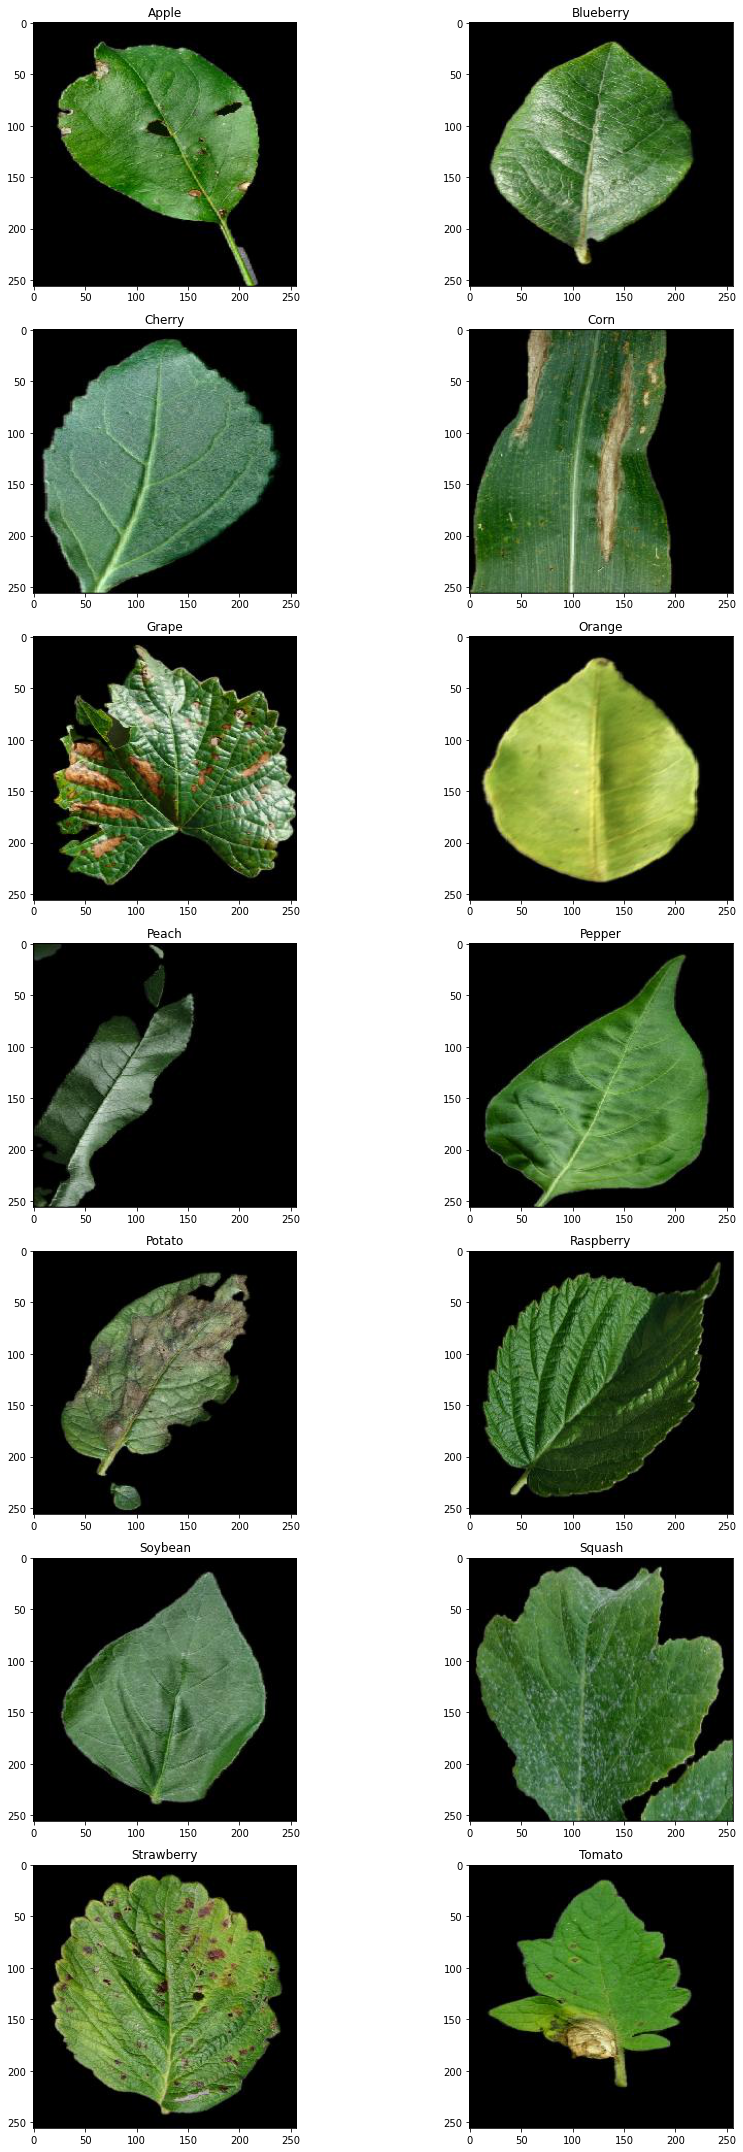

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Inspect dataset structure on disk
print("Depth 0 (leaves_test_overUnder_sampled)")
print("-------")
!ls leaves_test_overUnder_sampled
print()
print("Depth 1 (e.g., leaves_test_overUnder_sampled/training)")
print("------------------------")
!ls leaves_test_overUnder_sampled/train
print()
print("Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)")
print("----------------------------")
!ls leaves_test_overUnder_sampled/train/Blueberry

Depth 0 (leaves_test_overUnder_sampled)
-------
test  train  val

Depth 1 (e.g., leaves_test_overUnder_sampled/training)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)
----------------------------
0_01840.jpg  01827.jpg	02005.jpg  02190.jpg		180_02029.jpg
01647.jpg    01828.jpg	02006.jpg  02191.jpg		18_01953.jpg
01649.jpg    01829.jpg	02007.jpg  02193.jpg		181_01653.jpg
01650.jpg    01830.jpg	02008.jpg  02195.jpg		182_14_01953.jpg
01652.jpg    01831.jpg	02009.jpg  02196.jpg		183_02081.jpg
01653.jpg    01832.jpg	02012.jpg  02197.jpg		184_01996.jpg
01654.jpg    01833.jpg	02014.jpg  02198.jpg		185_01973.jpg
01655.jpg    01835.jpg	02015.jpg  02199.jpg		186_01890.jpg
01656.jpg    01837.jpg	02019.jpg  02203.jpg		187_125_02212.jpg
01657.jpg    01838.jpg	02022.jpg  02205.jpg		188_02127.jpg
01658.jpg    01840.jpg	02023.jpg  022

#Data Generator

Import:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1/255.)
aug_valid_data_gen = ImageDataGenerator(rotation_range=180,# --- N.B. --- While trying to increase performances, we tried to perform data augmentation also here, because in some classes, like the raspberry one, when we oversampled the validation set, it contained many copies. Doing some researches, we found online that, sometimes, in some specific applications, this helped a little bit and we wanted to try
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.) #to be commented if used with dataset "_notest" (not recommended)



# class_mode parameter not inserted: cathegorical (one hot coding) is the default one, hence, it is not necessary
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,         #to be commented if used with dataset "_notest" (not recommended)
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None,
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 7700 images belonging to 14 classes.
Found 3500 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

Let's work first with the network, and then declaring callbacks and checkpoints

In [ ]:
# Model used:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

    # Return the model
    return model

Function which creates folders for callbacks

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):
  #saving checkpoints on drive. We need to change directory, hence, we need ../ to go back of on folder, from /content to /
  #N.B.: after this we don't need to go back, we did not change directory, we worked with the string of the path
  exps_dir = os.path.join('../gdrive/MyDrive/AN2DL/Checkpts/LucaA') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Building Model

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

#Training the model

In [ ]:
# Create folders and callbacks and fit
aug_bal_callbacks = create_folders_and_callbacks(model_name = 'aug_balanced_LowLearning') #the model name will generate the folder of this single experiment

# restore checkpoints: (uncomment if needed)
#model.load_weights('/gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_10-10-02/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_valid_gen,
    callbacks = aug_bal_callbacks,
).history

Epoch 1/200
963/963 [==============================] - ETA: 0s - loss: 2.3328 - accuracy: 0.2027

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 145s 133ms/step - loss: 2.3328 - accuracy: 0.2027 - val_loss: 1.9292 - val_accuracy: 0.3400
Epoch 2/200
963/963 [==============================] - ETA: 0s - loss: 1.8133 - accuracy: 0.3851

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 1.8133 - accuracy: 0.3851 - val_loss: 1.6044 - val_accuracy: 0.4543
Epoch 3/200
963/963 [==============================] - ETA: 0s - loss: 1.4913 - accuracy: 0.5013

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 1.4913 - accuracy: 0.5013 - val_loss: 1.3395 - val_accuracy: 0.5417
Epoch 4/200
963/963 [==============================] - ETA: 0s - loss: 1.3443 - accuracy: 0.5517

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 127s 132ms/step - loss: 1.3443 - accuracy: 0.5517 - val_loss: 1.2624 - val_accuracy: 0.5820
Epoch 5/200
963/963 [==============================] - ETA: 0s - loss: 1.2141 - accuracy: 0.5981

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 127s 132ms/step - loss: 1.2141 - accuracy: 0.5981 - val_loss: 1.0967 - val_accuracy: 0.6454
Epoch 6/200
963/963 [==============================] - ETA: 0s - loss: 1.1075 - accuracy: 0.6249

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 127s 132ms/step - loss: 1.1075 - accuracy: 0.6249 - val_loss: 1.3079 - val_accuracy: 0.5689
Epoch 7/200
963/963 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.6500

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 1.0525 - accuracy: 0.6500 - val_loss: 1.0503 - val_accuracy: 0.6471
Epoch 8/200
963/963 [==============================] - ETA: 0s - loss: 0.9845 - accuracy: 0.6738

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 132ms/step - loss: 0.9845 - accuracy: 0.6738 - val_loss: 0.8660 - val_accuracy: 0.7211
Epoch 9/200
963/963 [==============================] - ETA: 0s - loss: 0.9241 - accuracy: 0.6934

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.9241 - accuracy: 0.6934 - val_loss: 0.8234 - val_accuracy: 0.7246
Epoch 10/200
963/963 [==============================] - ETA: 0s - loss: 0.8766 - accuracy: 0.7105

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 127s 132ms/step - loss: 0.8766 - accuracy: 0.7105 - val_loss: 0.8019 - val_accuracy: 0.7363
Epoch 11/200
963/963 [==============================] - ETA: 0s - loss: 0.8206 - accuracy: 0.7255

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.8206 - accuracy: 0.7255 - val_loss: 0.7221 - val_accuracy: 0.7660
Epoch 12/200
963/963 [==============================] - ETA: 0s - loss: 0.7740 - accuracy: 0.7462

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.7740 - accuracy: 0.7462 - val_loss: 0.7454 - val_accuracy: 0.7586
Epoch 13/200
963/963 [==============================] - ETA: 0s - loss: 0.7344 - accuracy: 0.7612

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.7344 - accuracy: 0.7612 - val_loss: 0.6975 - val_accuracy: 0.7669
Epoch 14/200
963/963 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7705

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.7010 - accuracy: 0.7705 - val_loss: 0.5998 - val_accuracy: 0.7974
Epoch 15/200
963/963 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.7905

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.6525 - accuracy: 0.7905 - val_loss: 0.5684 - val_accuracy: 0.8177
Epoch 16/200
963/963 [==============================] - ETA: 0s - loss: 0.6354 - accuracy: 0.7927

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.6354 - accuracy: 0.7927 - val_loss: 0.6828 - val_accuracy: 0.7694
Epoch 17/200
963/963 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.7970

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.6064 - accuracy: 0.7970 - val_loss: 0.5934 - val_accuracy: 0.8106
Epoch 18/200
963/963 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.8151

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.5684 - accuracy: 0.8151 - val_loss: 0.5502 - val_accuracy: 0.8049
Epoch 19/200
963/963 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.8213

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.5520 - accuracy: 0.8213 - val_loss: 0.5009 - val_accuracy: 0.8306
Epoch 20/200
963/963 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.8271

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.5258 - accuracy: 0.8271 - val_loss: 0.4550 - val_accuracy: 0.8534
Epoch 21/200
963/963 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.8382

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.4995 - accuracy: 0.8382 - val_loss: 0.4957 - val_accuracy: 0.8400
Epoch 22/200
963/963 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8431

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.4680 - accuracy: 0.8431 - val_loss: 0.4182 - val_accuracy: 0.8603
Epoch 23/200
963/963 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8464

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.4612 - accuracy: 0.8464 - val_loss: 0.4588 - val_accuracy: 0.8437
Epoch 24/200
963/963 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.8534

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.4475 - accuracy: 0.8534 - val_loss: 0.3747 - val_accuracy: 0.8711
Epoch 25/200
963/963 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.8562

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.4386 - accuracy: 0.8562 - val_loss: 0.3444 - val_accuracy: 0.8846
Epoch 26/200
963/963 [==============================] - ETA: 0s - loss: 0.4176 - accuracy: 0.8668

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.4176 - accuracy: 0.8668 - val_loss: 0.5367 - val_accuracy: 0.8200
Epoch 27/200
963/963 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8739

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.3914 - accuracy: 0.8739 - val_loss: 0.3988 - val_accuracy: 0.8657
Epoch 28/200
963/963 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8696

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.4017 - accuracy: 0.8696 - val_loss: 0.3174 - val_accuracy: 0.8897
Epoch 29/200
963/963 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8762

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.3735 - accuracy: 0.8762 - val_loss: 0.3321 - val_accuracy: 0.8931
Epoch 30/200
963/963 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8756

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.3708 - accuracy: 0.8756 - val_loss: 0.2942 - val_accuracy: 0.9060
Epoch 31/200
963/963 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.8814

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.3677 - accuracy: 0.8814 - val_loss: 0.3877 - val_accuracy: 0.8703
Epoch 32/200
963/963 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8869

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.3492 - accuracy: 0.8869 - val_loss: 0.3467 - val_accuracy: 0.8851
Epoch 33/200
963/963 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8881

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.3343 - accuracy: 0.8881 - val_loss: 0.3009 - val_accuracy: 0.9014
Epoch 34/200
963/963 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8968

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.3217 - accuracy: 0.8968 - val_loss: 0.3654 - val_accuracy: 0.8751
Epoch 35/200
963/963 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.8964

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.3210 - accuracy: 0.8964 - val_loss: 0.2922 - val_accuracy: 0.9049
Epoch 36/200
963/963 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8952

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.3068 - accuracy: 0.8952 - val_loss: 0.2850 - val_accuracy: 0.9049
Epoch 37/200
963/963 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.9062

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2910 - accuracy: 0.9062 - val_loss: 0.2835 - val_accuracy: 0.9066
Epoch 38/200
963/963 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.9055

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2876 - accuracy: 0.9055 - val_loss: 0.3199 - val_accuracy: 0.8943
Epoch 39/200
963/963 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.9075

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2885 - accuracy: 0.9075 - val_loss: 0.2567 - val_accuracy: 0.9197
Epoch 40/200
963/963 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.9082

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2789 - accuracy: 0.9082 - val_loss: 0.2558 - val_accuracy: 0.9154
Epoch 41/200
963/963 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.9086

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 132ms/step - loss: 0.2842 - accuracy: 0.9086 - val_loss: 0.2899 - val_accuracy: 0.9071
Epoch 42/200
963/963 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.9066

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2878 - accuracy: 0.9066 - val_loss: 0.2632 - val_accuracy: 0.9091
Epoch 43/200
963/963 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9179

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2524 - accuracy: 0.9179 - val_loss: 0.2326 - val_accuracy: 0.9223
Epoch 44/200
963/963 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9178

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2502 - accuracy: 0.9178 - val_loss: 0.2186 - val_accuracy: 0.9331
Epoch 45/200
963/963 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.9182

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2535 - accuracy: 0.9182 - val_loss: 0.2694 - val_accuracy: 0.9043
Epoch 46/200
963/963 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9248

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2338 - accuracy: 0.9248 - val_loss: 0.2418 - val_accuracy: 0.9194
Epoch 47/200
963/963 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9221

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2349 - accuracy: 0.9221 - val_loss: 0.2198 - val_accuracy: 0.9274
Epoch 48/200
963/963 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9255

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2249 - accuracy: 0.9255 - val_loss: 0.2140 - val_accuracy: 0.9306
Epoch 49/200
963/963 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9251

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2263 - accuracy: 0.9251 - val_loss: 0.2455 - val_accuracy: 0.9243
Epoch 50/200
963/963 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9260

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2303 - accuracy: 0.9260 - val_loss: 0.2532 - val_accuracy: 0.9183
Epoch 51/200
963/963 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9258

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2168 - accuracy: 0.9258 - val_loss: 0.2294 - val_accuracy: 0.9277
Epoch 52/200
963/963 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9290

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.2163 - accuracy: 0.9290 - val_loss: 0.2845 - val_accuracy: 0.9051
Epoch 53/200
963/963 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9352

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.2111 - accuracy: 0.9352 - val_loss: 0.2143 - val_accuracy: 0.9294
Epoch 54/200
963/963 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9348

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2045 - accuracy: 0.9348 - val_loss: 0.2220 - val_accuracy: 0.9271
Epoch 55/200
963/963 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9309

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2018 - accuracy: 0.9309 - val_loss: 0.1700 - val_accuracy: 0.9431
Epoch 56/200
963/963 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9335

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1952 - accuracy: 0.9335 - val_loss: 0.1884 - val_accuracy: 0.9397
Epoch 57/200
963/963 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9342

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.2003 - accuracy: 0.9342 - val_loss: 0.2051 - val_accuracy: 0.9337
Epoch 58/200
963/963 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9394

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.1799 - accuracy: 0.9394 - val_loss: 0.1853 - val_accuracy: 0.9386
Epoch 59/200
963/963 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9378

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.1937 - accuracy: 0.9378 - val_loss: 0.1784 - val_accuracy: 0.9420
Epoch 60/200
963/963 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9360

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1950 - accuracy: 0.9360 - val_loss: 0.2418 - val_accuracy: 0.9229
Epoch 61/200
963/963 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9416

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1792 - accuracy: 0.9416 - val_loss: 0.1682 - val_accuracy: 0.9463
Epoch 62/200
963/963 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9392

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 128s 133ms/step - loss: 0.1808 - accuracy: 0.9392 - val_loss: 0.2028 - val_accuracy: 0.9351
Epoch 63/200
963/963 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9468

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1655 - accuracy: 0.9468 - val_loss: 0.1568 - val_accuracy: 0.9489
Epoch 64/200
963/963 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9438

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1684 - accuracy: 0.9438 - val_loss: 0.1760 - val_accuracy: 0.9420
Epoch 65/200
963/963 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9452

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1641 - accuracy: 0.9452 - val_loss: 0.2282 - val_accuracy: 0.9249
Epoch 66/200
963/963 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9492

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1582 - accuracy: 0.9492 - val_loss: 0.1923 - val_accuracy: 0.9314
Epoch 67/200
963/963 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9471

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1644 - accuracy: 0.9471 - val_loss: 0.1757 - val_accuracy: 0.9443
Epoch 68/200
963/963 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9488

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1574 - accuracy: 0.9488 - val_loss: 0.1518 - val_accuracy: 0.9520
Epoch 69/200
963/963 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9427

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1740 - accuracy: 0.9427 - val_loss: 0.1670 - val_accuracy: 0.9457
Epoch 70/200
963/963 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9499

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1535 - accuracy: 0.9499 - val_loss: 0.1781 - val_accuracy: 0.9406
Epoch 71/200
963/963 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9494

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1514 - accuracy: 0.9494 - val_loss: 0.1776 - val_accuracy: 0.9463
Epoch 72/200
963/963 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9481

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1501 - accuracy: 0.9481 - val_loss: 0.1617 - val_accuracy: 0.9457
Epoch 73/200
963/963 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9497

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1588 - accuracy: 0.9497 - val_loss: 0.1423 - val_accuracy: 0.9563
Epoch 74/200
963/963 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9538

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1443 - accuracy: 0.9538 - val_loss: 0.2032 - val_accuracy: 0.9420
Epoch 75/200
963/963 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9532

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1469 - accuracy: 0.9532 - val_loss: 0.1586 - val_accuracy: 0.9500
Epoch 76/200
963/963 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9490

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 129s 134ms/step - loss: 0.1501 - accuracy: 0.9490 - val_loss: 0.2701 - val_accuracy: 0.9120
Epoch 77/200
963/963 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9501

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 130s 135ms/step - loss: 0.1462 - accuracy: 0.9501 - val_loss: 0.1803 - val_accuracy: 0.9400
Epoch 78/200
963/963 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9548

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1283 - accuracy: 0.9548 - val_loss: 0.1770 - val_accuracy: 0.9477
Epoch 79/200
963/963 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9540

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1341 - accuracy: 0.9540 - val_loss: 0.1765 - val_accuracy: 0.9443
Epoch 80/200
963/963 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9530

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1357 - accuracy: 0.9530 - val_loss: 0.1345 - val_accuracy: 0.9577
Epoch 81/200
963/963 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9549

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1337 - accuracy: 0.9549 - val_loss: 0.1479 - val_accuracy: 0.9537
Epoch 82/200
963/963 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9548

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1382 - accuracy: 0.9548 - val_loss: 0.1253 - val_accuracy: 0.9591
Epoch 83/200
963/963 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9558

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1390 - accuracy: 0.9558 - val_loss: 0.2171 - val_accuracy: 0.9309
Epoch 84/200
963/963 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9565

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1351 - accuracy: 0.9565 - val_loss: 0.1983 - val_accuracy: 0.9380
Epoch 85/200
963/963 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9568

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.1323 - accuracy: 0.9568 - val_loss: 0.1668 - val_accuracy: 0.9509
Epoch 86/200
963/963 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9610

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1276 - accuracy: 0.9610 - val_loss: 0.1507 - val_accuracy: 0.9523
Epoch 87/200
963/963 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9595

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1190 - accuracy: 0.9595 - val_loss: 0.1474 - val_accuracy: 0.9554
Epoch 88/200
963/963 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9584

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1232 - accuracy: 0.9584 - val_loss: 0.1942 - val_accuracy: 0.9403
Epoch 89/200
963/963 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9592

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1213 - accuracy: 0.9592 - val_loss: 0.1391 - val_accuracy: 0.9594
Epoch 90/200
963/963 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9605

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1232 - accuracy: 0.9605 - val_loss: 0.1349 - val_accuracy: 0.9583
Epoch 91/200
963/963 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9590

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 131s 136ms/step - loss: 0.1253 - accuracy: 0.9590 - val_loss: 0.1420 - val_accuracy: 0.9551
Epoch 92/200
963/963 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9605

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_Nov17_20-22-11/ckpts/cp.ckpt/assets


963/963 [==============================] - 132s 137ms/step - loss: 0.1208 - accuracy: 0.9605 - val_loss: 0.1408 - val_accuracy: 0.9531


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/AN2DL/models

/gdrive/MyDrive/AN2DL/models


In [ ]:
# Save best epoch model
model.save("Models/LucaA/Augmented_Balanced_LowLearning")

INFO:tensorflow:Assets written to: Models/LucaA/Augmented_Balanced_LowLearning/assets


INFO:tensorflow:Assets written to: Models/LucaA/Augmented_Balanced_LowLearning/assets


#Plot training error and validation error

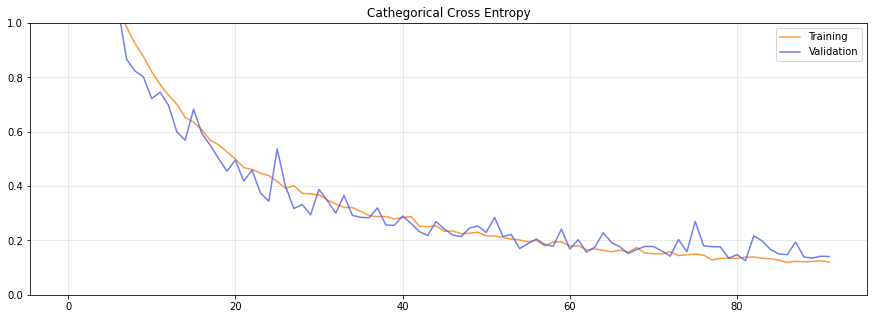

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Cathegorical Cross Entropy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Testing
N.B.: this cells can be executed only if considering the dataset with the test folder (recommend to use the dataset with the test folder)

In [ ]:
cd /content

/content


In [ ]:
model_to_be_tested = tfk.models.load_model("../gdrive/MyDrive/AN2DL/models/Models/LucaA/Augmented_Balanced_LowLearning")
model_to_be_tested_metrics = model_to_be_tested.evaluate(test_gen, return_dict=True)

224/224 [==============================] - 4s 17ms/step - loss: 0.3767 - accuracy: 0.8952
